In [1]:
# This code is based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
# and https://keras.io/examples/rl/deep_q_network_breakout/

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from collections import namedtuple
from PIL import Image

env = gym.make("Breakout-v4")

# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Determine if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Used to save model when running notebook in Colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Store the information needed to calculate q-values
Transition = namedtuple("Transition", 
                        ("state", "action", "next_state", "reward"))

# Class used to track Transitions
# We sample from the list of previous Transitions instead of always
# using the most recent one, which improves stability
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w, output_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Number of linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 8, 4), 4, 2), 3, 1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 8, 4), 4, 2), 3, 1)
        linear_input_size = convw * convh * 64

        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, output_size)

    # Called with either one element to determine next action, or a batch
    # during optimization.
    def forward(self, x):
        x = x.to(torch.float32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

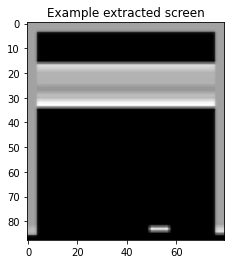

In [5]:
transform = T.Compose([T.ToPILImage(), 
                       T.Resize(80, interpolation=Image.CUBIC),
                       T.Grayscale(),
                       T.ToTensor()])

def get_screen():
    # Transpose screen into torch order (CHW).
    screen = env.render(mode="rgb_array").transpose((2, 0, 1))
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32)
    screen = torch.Tensor(screen)
    # Resize, add a batch dimension (BCHW), and crop
    screen = transform(screen).unsqueeze(0).to(device)
    screen = screen.to(torch.float16)
    screen = screen[:, :, 12:100, :80]
    return screen

env.reset()
example_screen = get_screen().squeeze(0).squeeze(0).to(torch.float32).cpu().numpy()
plt.figure()
plt.imshow(example_screen, cmap='gray')
plt.title("Example extracted screen")
plt.show()

In [6]:
# Hyperparameters chosen to match DeepMind paper
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.1
EPS_RANDOM_FRAMES = 50000
EPS_GREEDY_FRAMES = 1000000
TARGET_UPDATE = 10000

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym.
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.00025)
memory = ReplayMemory(100000)

def select_action(state, eps_threshold):
    sample = np.random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[np.random.randint(n_actions)]], device=device, dtype=torch.long)

In [7]:
def optimize_model():
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would have been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would have been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        if torch.norm(param.grad.data) > 1: # Clip gradient based on norm
            param.grad.data = param.grad.data / torch.norm(param.grad.data)
    optimizer.step()

In [8]:
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
done_count = 0
current_lives = 0
eps = EPS_START

env.reset()
state = torch.cat((get_screen(), get_screen(), get_screen(), get_screen()), axis=1)

In [9]:
while True:
    # Initialize the environment and state
    if current_lives == 0:
        current_lives = 5
        env.reset()
        state = torch.cat((get_screen(), get_screen(), get_screen(), get_screen()), axis=1)
      
    next_state = state    
    episode_reward = 0

    for i in range(1, 10000):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Select and perform an action
        action = select_action(state, eps)
        _, reward, game_over, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        episode_reward += reward.detach().cpu().numpy()

        # Determine if a life was lost; we consider this as "done"
        if info["ale.lives"] < current_lives:
            current_lives = info["ale.lives"]
            done = True
        else:
            done = False

        # Observe new state
        if not done:
            next_state = torch.cat((next_state, get_screen()), axis=1)
            next_state = next_state[:, 1:, :, :]
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        if not done:
            state = next_state

        # Perform one step of the optimization (on the target network)
        if frame_count % 4 == 0 and done_count > BATCH_SIZE:
            optimize_model()

        # Decay probability of taking random action
        if frame_count < EPS_RANDOM_FRAMES:
            eps = EPS_START
        else:
            eps -= (EPS_START - EPS_END) / EPS_GREEDY_FRAMES
            eps = max(eps, EPS_END)
        
        # Update the target network, copying all weights and biases in DQN
        if frame_count % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print(f"running reward: {running_reward:.2f} at episode {episode_count}, frame count {frame_count}")
            torch.save(target_net, "/content/drive/My Drive/target_net.pt")
        
        # If done, end the episode
        if done:
            done_count += 1
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print(f"Solved at episode {episode_count}!")
        torch.save(target_net, "/content/drive/My Drive/target_net.pt")
        break

print("Complete")
env.close()

running reward: 0.25 at episode 201, frame count 10000
running reward: 0.34 at episode 402, frame count 20000
running reward: 0.22 at episode 609, frame count 30000
running reward: 0.31 at episode 805, frame count 40000
running reward: 0.31 at episode 1006, frame count 50000
running reward: 0.23 at episode 1213, frame count 60000
running reward: 0.23 at episode 1419, frame count 70000
running reward: 0.21 at episode 1625, frame count 80000
running reward: 0.32 at episode 1834, frame count 90000
running reward: 0.24 at episode 2044, frame count 100000
running reward: 0.27 at episode 2249, frame count 110000
running reward: 0.28 at episode 2449, frame count 120000
running reward: 0.32 at episode 2648, frame count 130000
running reward: 0.27 at episode 2847, frame count 140000
running reward: 0.27 at episode 3058, frame count 150000
running reward: 0.36 at episode 3247, frame count 160000
running reward: 0.27 at episode 3447, frame count 170000
running reward: 0.19 at episode 3665, frame 

KeyboardInterrupt: ignored